In [9]:
import numpy as np
import geopandas as gpd
from scipy.stats import norm,gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
from pysrc.sampling import theta_adj_reg_data
theta_reg = gpd.read_file("/project/lhansen/HMC_re/project-amazon/data/calibration/hmc/theta_reg.geojson")
theta_fit = gpd.read_file("/project/lhansen/HMC_re/project-amazon/data/calibration/hmc/theta_fit.geojson")

X = theta_reg.iloc[:, 0:8].values  # Columns 1 to 6 as X
Y = theta_reg.iloc[:, 8].values    # Column 7 as Y
site_ids = theta_reg.iloc[:, -2].values -1   # Column 8 as site_ids
site_ids = site_ids.astype(int)
weights = theta_reg.iloc[:,9].values
weights = weights/np.mean(weights)


np.random.seed(45)

In [12]:
def gibbs_sampling_with_data(X, Y, site_ids,weights,n_iterations=10000, beta_prior_mean=None, beta_prior_cov=None, 
                             eta_prior_shape=2, eta_prior_scale=1, nu_prior_shape=2, nu_prior_scale=1):
    n_data, n_features = X.shape
    n_sites = len(np.unique(site_ids))
    
    # Initialize priors
    if beta_prior_mean is None:
        beta_prior_mean = np.zeros(n_features)
    if beta_prior_cov is None:
        beta_prior_cov = np.eye(n_features)   # Large prior variance
    
    # Initialize Gibbs sampling arrays
    beta_samples = np.zeros((n_iterations, n_features))
    eta_samples = np.zeros(n_iterations)
    nu_samples = np.zeros(n_iterations)
    V_samples = np.zeros((n_iterations, n_sites))
    
    # Initial values based on prior
    beta_current = np.random.multivariate_normal(beta_prior_mean, beta_prior_cov)
    eta_current = gamma.rvs(a=eta_prior_shape, scale=1/eta_prior_scale)
    nu_current = gamma.rvs(a=nu_prior_shape, scale=1/nu_prior_scale)
    V_current = np.zeros(n_sites)+0.01
    
    sq_weight_matrix=np.diag(np.sqrt(weights))
    weight_X=sq_weight_matrix@X
    weight_Y=sq_weight_matrix@Y
    
    # Gibbs sampler
    for i in tqdm(range(n_iterations), desc="Gibbs Sampling Progress"):
        # Step i: Draw beta conditioned on V, eta, and data
        precision_beta = eta_current * (weight_X.T @ weight_X)
        mean_beta = np.linalg.inv(precision_beta) @ ( eta_current * weight_X.T @ (weight_Y - sq_weight_matrix@V_current[site_ids]))
        beta_current = np.random.multivariate_normal(mean_beta, np.linalg.inv(precision_beta))
        beta_samples[i, :] = beta_current
        
        # Step ii: Draw eta conditioned on V and data
        residuals = weight_Y - weight_X @ beta_current - sq_weight_matrix@V_current[site_ids]
        eta_shape_post =    n_data / 2
        eta_scale_post =  0.5 * np.sum(residuals**2)
        eta_current = gamma.rvs(a=eta_shape_post, scale=1/eta_scale_post)
        eta_samples[i] = eta_current
        
        # Step iii: Draw nu conditioned on V
        nu_shape_post =  n_sites / 2
        nu_scale_post =  0.5 * np.sum(V_current**2) 
        nu_current = gamma.rvs(a=nu_shape_post, scale=1/nu_scale_post)
        # nu_current = 1e10
        nu_samples[i] = nu_current
        
        # nu_current = 1e10
        # nu_samples[i] = nu_current
        
        # Step iv: Draw V_j conditioned on beta, nu, eta, and data
        for j in range(n_sites):
            site_mask = site_ids == j
            # n_j = np.sum(site_mask)
            n_j = np.sum(weights[site_mask])
            weight_matrix_sub=np.diag(weights[site_mask])
            V_bar_j = np.sum(weight_matrix_sub@Y[site_mask] - weight_matrix_sub@X[site_mask] @ beta_current)
            mean_V_j = ( eta_current * V_bar_j) / (n_j * eta_current + nu_current)
            precision_V_j = n_j * eta_current + nu_current
            V_current[j] = np.random.normal(mean_V_j, np.sqrt(1 / precision_V_j))
        V_samples[i, :] = V_current
    
    
    beta_samples_final = beta_samples[5000:,:]
    eta_samples_final = eta_samples[5000:]
    nu_samples_final = nu_samples[5000:]
    V_samples_final = V_samples[5000:,:]
    
    # Posterior means
    beta_posterior_mean = beta_samples_final.mean(axis=0)
    eta_posterior_mean = eta_samples_final.mean()
    nu_posterior_mean = nu_samples_final.mean()
    
    return beta_posterior_mean, eta_posterior_mean, nu_posterior_mean, beta_samples_final, eta_samples_final, nu_samples_final, V_samples_final

# Run Gibbs sampling with the extracted data
# Assuming X, Y, and site_ids are already defined
beta_posterior_mean, eta_posterior_mean, nu_posterior_mean, beta_samples, eta_samples, nu_samples, V_samples = gibbs_sampling_with_data(X=X, Y=Y, site_ids=site_ids,weights=weights)

# Output the results
print(f"Posterior mean of beta: {beta_posterior_mean}")
print(f"Posterior mean of eta: {eta_posterior_mean}")
print(f"Posterior mean of nu: {nu_posterior_mean}")


Gibbs Sampling Progress: 100%|██████████| 30000/30000 [02:42<00:00, 184.97it/s]

Posterior mean of beta: [-4.05936685e+01 -1.06721443e-01 -5.64478466e-03  3.00821095e+00
 -6.09684745e-02 -6.63667308e-03 -2.35587276e-04  2.38985841e+00]
Posterior mean of eta: 4.137701752523721
Posterior mean of nu: 10.129815055136445


In [16]:

mean_pa_2017=44.97362
theta_fit_df_78= gpd.read_file("/project/lhansen/HMC_re/project-amazon/data/calibration/hmc/theta_fit_78.geojson")
X_fit = theta_adj_reg_data(78,theta_fit_df_78)['X_theta']
weights = theta_adj_reg_data(78,theta_fit_df_78)['G_theta']
fit_ids = theta_fit_df_78["group_id"].values -1   # Column 8 as site_ids
fit_ids = fit_ids.astype(int)
site_theta= np.mean(np.exp(X_fit @ beta_samples.T + V_samples[:, fit_ids].T),axis=1)
theta_78 = weights@site_theta/44.97362
# theta_78_df = pd.DataFrame(theta_78, columns=['theta_fit'])
# theta_78_df.to_csv(data_dir/'theta_fit_78.csv', index=False)


In [117]:
import pandas as pd
theta_iid=pd.read_csv("theta.csv").to_numpy()
# theta_iid=np.mean(theta_iid,axis=0)

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

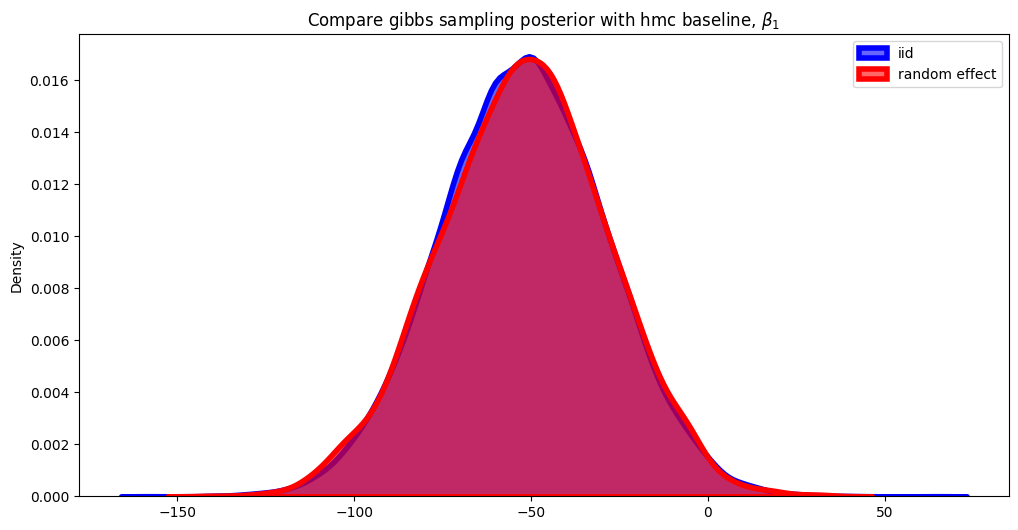

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

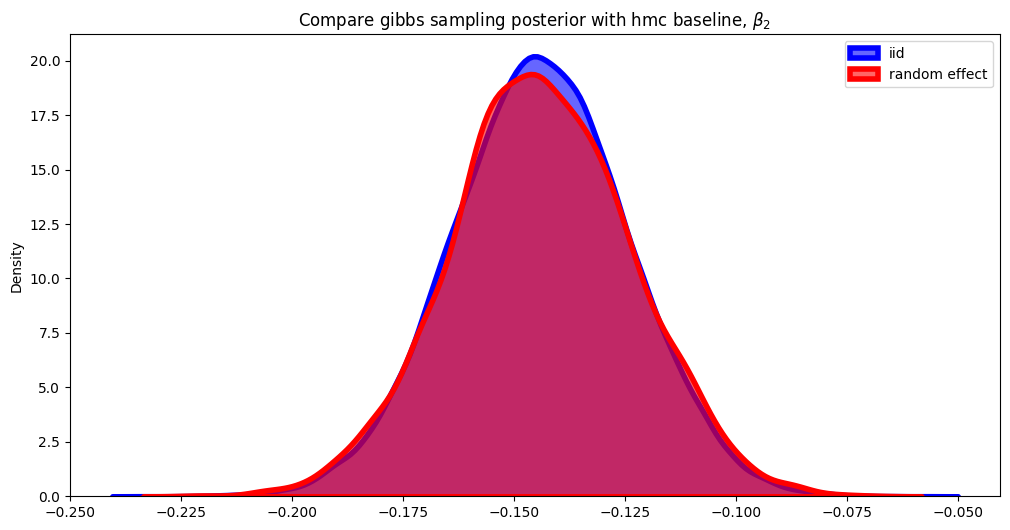

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

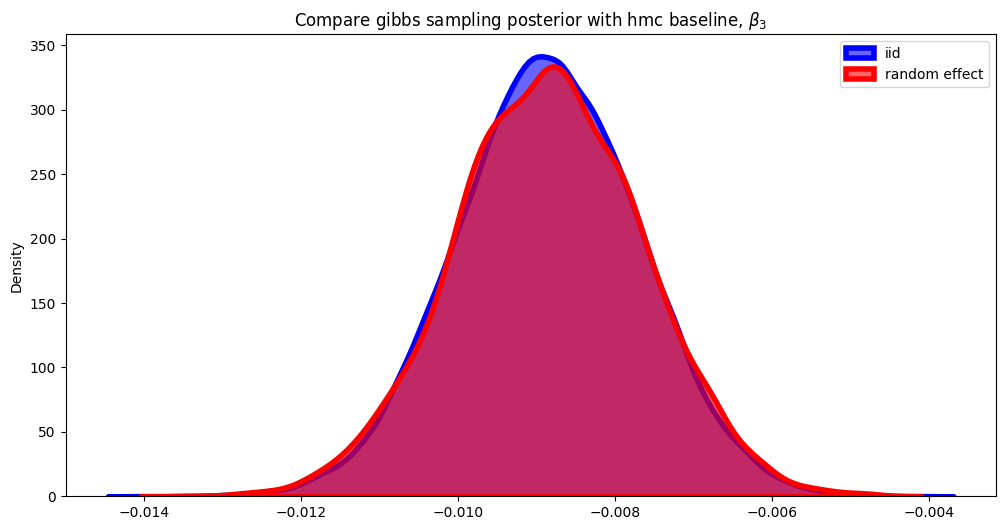

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

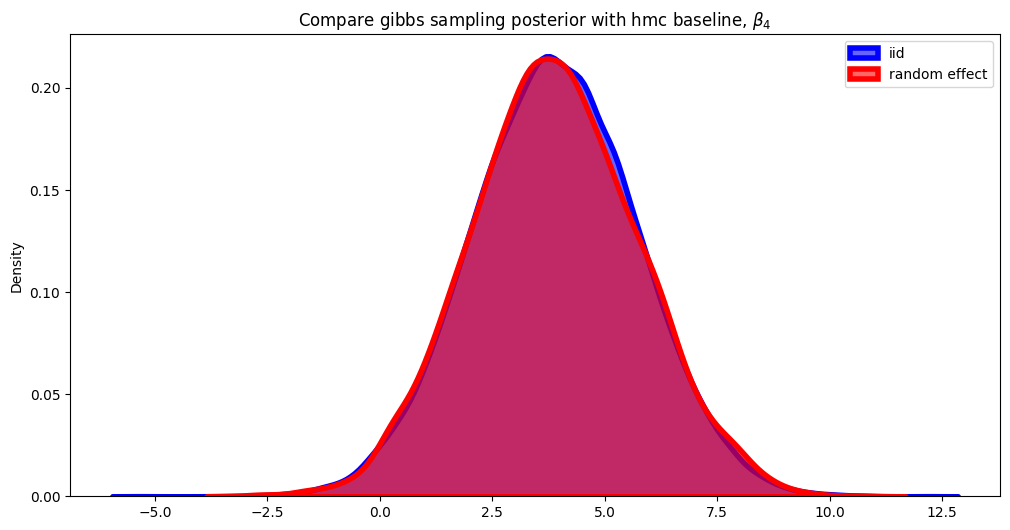

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

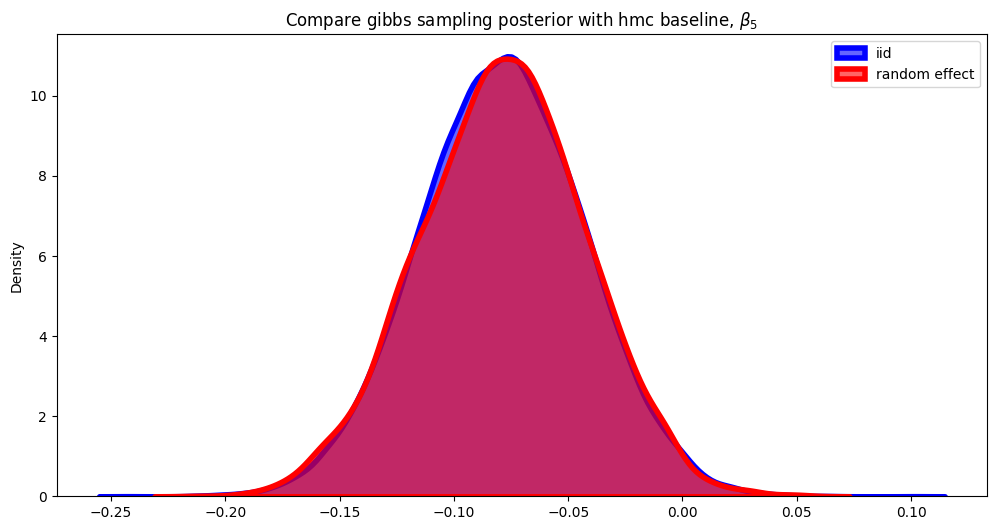

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

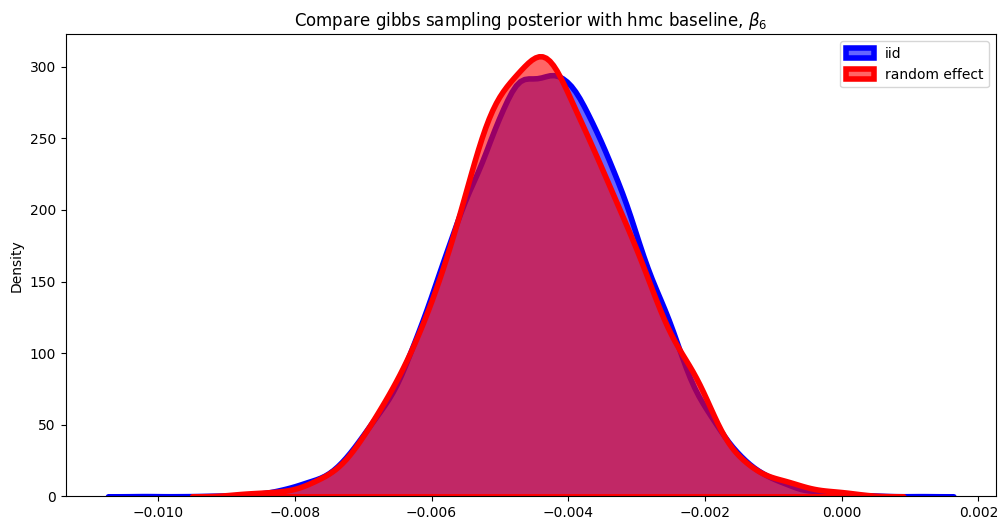

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

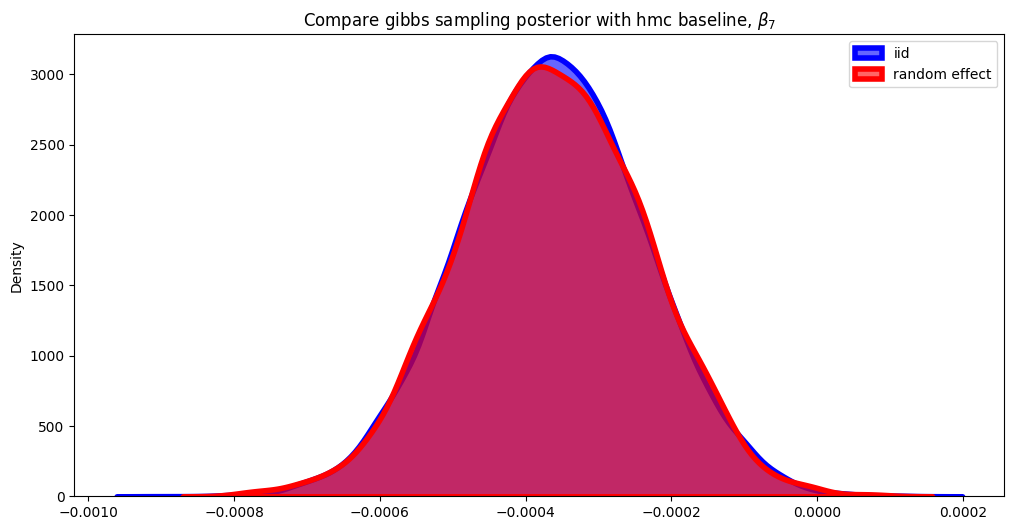

/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pengyu/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

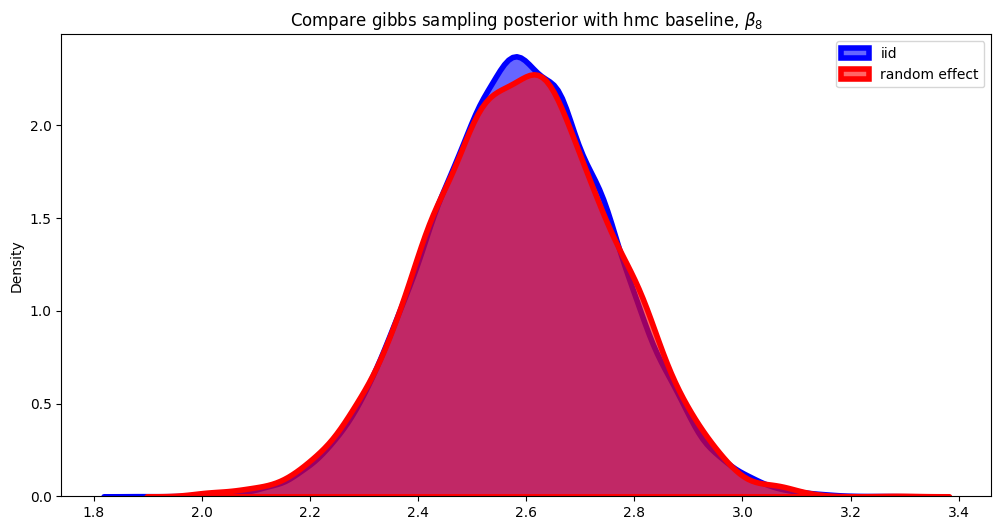

In [118]:
import seaborn as sns

for i in range(8):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(theta_iid[:, i], label='iid', color='blue', fill=True, alpha=0.6,linewidth=4) 
    sns.kdeplot(beta_samples[:, i], label='random effect', color='red', fill=True, alpha=0.6,linewidth=4)  
    plt.title(r'Compare gibbs sampling posterior with hmc baseline, $\beta_'+str(i+1)+'$')
    plt.legend()
    plt.savefig('results/test/beta'+str(i+1)+'.png')
    plt.show()

In [ ]:
# np.savetxt("prior_beta_samples.csv", beta_samples, delimiter=",")
# np.savetxt("prior_eta_samples.csv", eta_samples, delimiter=",")
# np.savetxt("prior_nu_samples.csv", nu_samples, delimiter=",")
# np.savetxt("prior_V_samples.csv", V_samples, delimiter=",")